# Estudio de la base de datos

La bioinformática se apoya en la clasificación de secuencias biológicas y la cuantificación de propiedades fisicoquímicas para resolver problemas biológicos, como la identificación de péptidos antimicrobianos, esenciales en el desarrollo de terapias contra patógenos resistentes. Los descriptores fisicoquímicos cuantifican propiedades como la hidrofobicidad y la carga eléctrica, transformando las secuencias en formatos cuantitativos que facilitan la distinción de los péptidos antimicrobianos.

En este notebook se analizará si existen sesgos entre las secuencias de las diferentes bases de datos utilizadas, considerando los diferentes predictores fisicoquímicos generados con ProPythia, así como otros atributos adicionales, como las Actividades y los Targets de cada secuencia. Además, compararemos estas bases de datos con nuestra base de datos final, denominada PPDB (Peptide Profiler Data Base).

ProPythia es una plataforma para la clasificación de secuencias biológicas (proteínas y ADN), centrada en el uso de descriptores fisicoquímicos y codificaciones de secuencias. Es una plataforma genérica, modular y semi-automatizada en Python que contiene funciones para la representación de secuencias y un pipeline robusto para el análisis de datos bioquímicos. La principal fortaleza y uso de este paquete es la DESCRIPCIÓN de SECUECIAS BIOLÓGICAS, un paso crucial para cualquier análisis bioinformático. Incluye:

    Cálculo de descriptores fisicoquímicos de proteínas (con paralelización disponible).
    Cálculo de diferentes codificaciones de proteínas.
    Cálculo de descriptores fisicoquímicos de ADN.
    Cálculo de diferentes codificaciones de ADN.
    Entrenamiento y uso de técnicas de incrustación de palabras.

ProPythia proporciona una infraestructura completa para el manejo y análisis de bases de datos biológicas, optimizando la identificación y clasificación de secuencias a través de la cuantificación precisa de sus propiedades fisicoquímicas (https://github.com/BioSystemsUM/propythia).

    Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: a Python package for protein classification based on machine and deep learning. Neurocomputing, 484, 172-182.

In [1]:
import sys
import os
# Obtener la ruta del directorio del script actual
current_script_directory = os.path.dirname(os.path.abspath('.'))

# Construir la ruta al directorio src
src_directory = os.path.join(current_script_directory, "..", "src")
srcpro_directory = os.path.join(current_script_directory, "..", "src/propythia")

# Agregar el directorio src a sys.path
sys.path.append(src_directory)
sys.path.append(srcpro_directory)

In [2]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import transformers
import torch


from propythia.protein.sequence import ReadSequence
from propythia.protein.descriptors import ProteinDescritors

### Preprocesamiento de la base de datos

Partimos de una base de datos que se creó anteriormente, resultado de la suma y unificación de diferentes bases de datos de péptidos antimicrobianos. De cada base de datos se tomó unicamente las secuancias peptídicas, su identificador asociado para cada base de datos y la actividad descrita. Posteriormente, mediante diferentes querys y joins con otras bases de datos, se fue añadiendo información extra, como el ID para cada secuencia en PubMed, Uniprot o APD3, además de el Target específico si se conocía. Así mismo, atendiendo a su actividad descrita, se catalogaron en AMP y noAMP.

A continuación se hará una limpieza de la base de datos para poder trabajar con ella con Propythia.

In [3]:
# Cargar el DataFrame desde el archivo CSV
data = pd.read_csv('files_results/db_all_stat.csv')

# Renombrar la columna a 'sequence' si es necesario
data.rename(columns={'Sequence': 'sequence'}, inplace=True)

El módulo ReadSequence de Propythia contiene funciones diseñadas para preprocesar las secuencias de proteínas, reemplazando o eliminando ciertos aminoácidos. La fase de preprocesamiento puede ser necesaria para calcular ciertas características o codificaciones de descriptores.

In [4]:
read_seqs = ReadSequence()
res = read_seqs.par_preprocessing(dataset= data, col = 'sequence', B ='N', Z = 'Q', U = 'C', O = 'K', J = 'I', X = '')
res

ID_Peptide PubMed_ID UniProt_ID  APD3_ID  \
0           FMDB1  18521593        NaN      NaN   
1        FMDB1000  18627167        NaN      NaN   
2        FMDB1001  18627167        NaN      NaN   
3        FMDB1002  18627167        NaN      NaN   
4        FMDB1003  18627167        NaN      NaN   
...           ...       ...        ...      ...   
46840  DRAMP18146       NaN        NaN      NaN   
46841  DRAMP18148       NaN        NaN      NaN   
46842  DRAMP18149       NaN        NaN      NaN   
46843  DRAMP01272       NaN        NaN      NaN   
46844  DRAMP00828       NaN        NaN   1066.0   

                                               sequence        Activity  \
0                                                    DP  Ace-inhibitory   
1                                           PVAPLQRSGPE  Ace-inhibitory   
2                                           PRSGNVGESGL  Ace-inhibitory   
3                                             VAPSRPTPR  Ace-inhibitory   
4                                                DIIIPD  Ace-inhibitory   
...                                                 ...             ...   
46840                 DCLGQWASCEPKNSKCCPNYACTWKYPWCRYRA    Insecticidal   
46841  ATCAGQDQTCKVTCDCCGERGECVCGGPCICRQGNFLIAWYKLASCKK    Insecticidal   
46842                DCGHLHDPCPNDRPGHRTCCIGLQCRYGKCLVRV    Insecticidal   
46843  ATCAGQDQPCKETCDCCGERGECVCGGPCICRQGYFWIAWYKLANCKK    Insecticidal   
46844                    GLPTCGETCFGGTCNTPGCTCDPWPVCTHN    Insecticidal   

      db_source Targets  Code    AMP  
0          FMDB     NaN     0  False  
1          FMDB     NaN     0  False  
2          FMDB     NaN     0  False  
3          FMDB     NaN     0  False  
4          FMDB     NaN     0  False  
...         ...     ...   ...    ...  
46840     DRAMP     NaN    31  False  
46841     DRAMP     NaN    31  False  
46842     DRAMP     NaN    31  False  
46843     DRAMP     NaN    31  False  
46844     DRAMP     NaN    31  False  

[46845 rows x 10 columns]

El módulo ProteinDescriptors es responsable de realizar el cálculo de varios descriptores basados en secuencias. 

In [5]:
# Hacer una copia del DataFrame sin duplicados para aplicar ProteinDescriptors
res_copy = res.copy()

descriptors_df = ProteinDescritors(dataset= res_copy,  col= 'sequence')
descriptors_df.dataset

ID_Peptide PubMed_ID UniProt_ID  APD3_ID  \
0           FMDB1  18521593        NaN      NaN   
1        FMDB1000  18627167        NaN      NaN   
2        FMDB1001  18627167        NaN      NaN   
3        FMDB1002  18627167        NaN      NaN   
4        FMDB1003  18627167        NaN      NaN   
...           ...       ...        ...      ...   
46584  DRAMP00785       NaN        NaN   1027.0   
46585  DRAMP00786       NaN        NaN   1028.0   
46586  DRAMP00787       NaN        NaN   1029.0   
46589  DRAMP00790       NaN        NaN   1032.0   
46616  DRAMP02126       NaN        NaN      NaN   

                             sequence        Activity db_source Targets  Code  \
0                                  DP  Ace-inhibitory      FMDB     NaN     0   
1                         PVAPLQRSGPE  Ace-inhibitory      FMDB     NaN     0   
2                         PRSGNVGESGL  Ace-inhibitory      FMDB     NaN     0   
3                           VAPSRPTPR  Ace-inhibitory      FMDB     NaN     0   
4                              DIIIPD  Ace-inhibitory      FMDB     NaN     0   
...                               ...             ...       ...     ...   ...   
46584  GLPVCGETCFGGTCNTPGCSCDPWPMCSRN      Anticancer     DRAMP     NaN    39   
46585   GVPICGETCVGGTCNTPGCSCSWPVCTRN      Anticancer     DRAMP     NaN    39   
46586   GLPICGETCVGGSCNTPGCSCSWPVCTRN      Anticancer     DRAMP     NaN    39   
46589  GVPVCGETCFGGTCNTPGCSCDPWPVCSRN      Anticancer     DRAMP     NaN    39   
46616          FIGSALKVLAGVLPSIVSWVKQ      Anticancer     DRAMP     NaN    39   

         AMP  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
46584  False  
46585  False  
46586  False  
46589  False  
46616  False  

[21016 rows x 10 columns]

Se calcularon descriptores mediante funciones de Propythia y otras manualmente.

In [6]:
## Cálculo de la frecuencia de aminoácidos dentro de la secuencia

df_aa_comp = descriptors_df.get_aa_comp(n_jobs=4)

In [7]:
# Calculo de frecuencias de aminoácidos según su naturaleza

# Categorías de aminoácidos
hidrofobicos = {'A', 'I', 'L', 'M', 'F', 'V', 'P', 'G'}
hidrofilicos = {'R', 'N', 'D', 'C', 'E', 'Q', 'H', 'K', 'S', 'T', 'Y', 'W'}
basicos = {'R', 'H', 'K'}
acidos = {'D', 'E'}
alifaticos = {'A', 'V', 'I', 'L'}

masas_aminoacidos = {
    'A': 89.09, 'R': 174.20, 'N': 132.12, 'D': 133.10, 'C': 121.15,
    'E': 147.13, 'Q': 146.15, 'G': 75.07, 'H': 155.16, 'I': 131.17,
    'L': 131.17, 'K': 146.19, 'M': 149.21, 'F': 165.19, 'P': 115.13,
    'S': 105.09, 'T': 119.12, 'W': 204.23, 'Y': 181.19, 'V': 117.15
}

def propiedades(secuencia):
    
    longitud = len(secuencia)
    conteos = {aa: secuencia.count(aa) for aa in set(secuencia)}
    faltantes = set(masas_aminoacidos.keys()) - set(secuencia)
    mas_frecuente = max(conteos, key=conteos.get, default=None)
    frecuencia_hidrofobicos = round(sum(conteos.get(aa, 0) for aa in hidrofobicos) / longitud, 2)
    frecuencia_hidrofilicos = round(sum(conteos.get(aa, 0) for aa in hidrofilicos) / longitud, 2)
    frecuencia_basicos = round(sum(conteos.get(aa, 0) for aa in basicos) / longitud, 2)
    frecuencia_acidos = round(sum(conteos.get(aa, 0) for aa in acidos) / longitud, 2)

    return pd.Series({
        'sequence': secuencia,
        'aa_missing': faltantes,
        'aa_more_freq': mas_frecuente,
        'hydrophobic_freq': frecuencia_hidrofobicos,
        'hydrophilic_freq': frecuencia_hidrofilicos,
        'basic_freq': frecuencia_basicos,
        'acid_freq': frecuencia_acidos,
    })

df_statistics = df_aa_comp['sequence'].apply(propiedades)

In [8]:
# Concatenamos los dos dataframes
df_aa_stat = pd.merge(df_aa_comp, df_statistics, on='sequence')

In [9]:
df_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21016 entries, 0 to 21015
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sequence          21016 non-null  object 
 1   aa_missing        21016 non-null  object 
 2   aa_more_freq      21016 non-null  object 
 3   hydrophobic_freq  21016 non-null  float64
 4   hydrophilic_freq  21016 non-null  float64
 5   basic_freq        21016 non-null  float64
 6   acid_freq         21016 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.1+ MB


In [10]:
# Cálculo de diferentes propiedades fisicoquímicas haciendo uso de librerias de Biopyhton
df_physicochemical = descriptors_df.get_all_physicochemical(ph=7, amide=False, n_jobs=6)

In [11]:
# Concatenar ambos cálculos
df_FQ = pd.merge(df_physicochemical, df_aa_stat, on='sequence')

In [12]:
# Fusionar la información procesada con el dataset original
final_data = pd.merge(data, df_FQ, on= 'sequence', how='left')

# Eliminar las columnas duplicadas con sufijos '_y'
columns_to_drop = [col for col in final_data.columns if col.endswith('_y')]
final_data.drop(columns=columns_to_drop, inplace=True)

# Renombrar las columnas que quedan con sufijos '_x'
final_data.columns = final_data.columns.str.replace('_x', '')

final_data

ID_Peptide PubMed_ID UniProt_ID  APD3_ID  \
0           FMDB1  18521593        NaN      NaN   
1        FMDB1000  18627167        NaN      NaN   
2        FMDB1001  18627167        NaN      NaN   
3        FMDB1002  18627167        NaN      NaN   
4        FMDB1003  18627167        NaN      NaN   
...           ...       ...        ...      ...   
46840  DRAMP18146       NaN        NaN      NaN   
46841  DRAMP18148       NaN        NaN      NaN   
46842  DRAMP18149       NaN        NaN      NaN   
46843  DRAMP01272       NaN        NaN      NaN   
46844  DRAMP00828       NaN        NaN   1066.0   

                                               sequence        Activity  \
0                                                    DP  Ace-inhibitory   
1                                           PVAPLQRSGPE  Ace-inhibitory   
2                                           PRSGNVGESGL  Ace-inhibitory   
3                                             VAPSRPTPR  Ace-inhibitory   
4                                                DIIIPD  Ace-inhibitory   
...                                                 ...             ...   
46840                 DCLGQWASCEPKNSKCCPNYACTWKYPWCRYRA    Insecticidal   
46841  ATCAGQDQTCKVTCDCCGERGECVCGGPCICRQGNFLIAWYKLASCKK    Insecticidal   
46842                DCGHLHDPCPNDRPGHRTCCIGLQCRYGKCLVRV    Insecticidal   
46843  ATCAGQDQPCKETCDCCGERGECVCGGPCICRQGYFWIAWYKLANCKK    Insecticidal   
46844                    GLPTCGETCFGGTCNTPGCTCDPWPVCTHN    Insecticidal   

      db_source Targets  Code    AMP  ...       T      W      Y       V  \
0          FMDB     NaN     0  False  ...   0.000  0.000  0.000   0.000   
1          FMDB     NaN     0  False  ...   0.000  0.000  0.000   9.091   
2          FMDB     NaN     0  False  ...   0.000  0.000  0.000   9.091   
3          FMDB     NaN     0  False  ...  11.111  0.000  0.000  11.111   
4          FMDB     NaN     0  False  ...   0.000  0.000  0.000   0.000   
...         ...     ...   ...    ...  ...     ...    ...    ...     ...   
46840     DRAMP     NaN    31  False  ...   3.030  9.091  9.091   0.000   
46841     DRAMP     NaN    31  False  ...   6.250  2.083  2.083   4.167   
46842     DRAMP     NaN    31  False  ...   2.941  0.000  2.941   5.882   
46843     DRAMP     NaN    31  False  ...   4.167  4.167  4.167   2.083   
46844     DRAMP     NaN    31  False  ...  20.000  3.333  0.000   3.333   

                                              aa_missing  aa_more_freq  \
0      {S, I, T, M, H, N, C, Y, V, E, A, R, Q, G, K, ...             D   
1                      {I, T, M, H, N, C, D, Y, K, W, F}             P   
2                   {I, T, A, M, H, Q, D, C, Y, K, W, F}             G   
3             {E, I, H, M, N, Q, D, C, Y, K, G, W, L, F}             P   
4      {S, T, M, H, N, C, Y, V, E, A, R, Q, G, K, W, ...             I   
...                                                  ...           ...   
46840                                    {I, H, M, F, V}             C   
46841                                             {H, M}             C   
46842                                 {E, S, A, M, W, F}             C   
46843                                          {H, M, S}             C   
46844                           {S, I, A, M, R, Q, Y, K}             T   

       hydrophobic_freq  hydrophilic_freq  basic_freq  acid_freq  
0                  0.50              0.50        0.00       0.50  
1                  0.64              0.36        0.09       0.09  
2                  0.55              0.45        0.09       0.09  
3                  0.56              0.44        0.22       0.00  
4                  0.67              0.33        0.00       0.33  
...                 ...               ...         ...        ...  
46840              0.24              0.76        0.15       0.06  
46841              0.38              0.62        0.12       0.08  
46842              0.38              0.62        0.24       0.09  
46843              0.35          

In [13]:
final_data.columns

Index(['ID_Peptide', 'PubMed_ID', 'UniProt_ID', 'APD3_ID', 'sequence',
       'Activity', 'db_source', 'Targets', 'Code', 'AMP', 'length', 'charge',
       'chargedensity', 'formulaC', 'formulaH', 'formulaN', 'formulaO',
       'formulaS', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp',
       'Gravy', 'Aromacity', 'IsoelectricPoint', 'Instability_index',
       'SecStruct_helix', 'SecStruct_turn', 'SecStruct_sheet',
       'Molar_extinction_coefficient_reduced',
       'Molar_extinction_coefficient_oxidized', 'aliphatic_index',
       'bomanindex', 'hydrophobic_ratio', 'A', 'R', 'N', 'D', 'C', 'E', 'Q',
       'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V',
       'aa_missing', 'aa_more_freq', 'hydrophobic_freq', 'hydrophilic_freq',
       'basic_freq', 'acid_freq'],
      dtype='object')

## Estadística

C:\Users\noral\AppData\Local\Temp\ipykernel_5080\4172125286.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=total_sequences_per_db.index, y=total_sequences_per_db.values, palette=colors_bd)


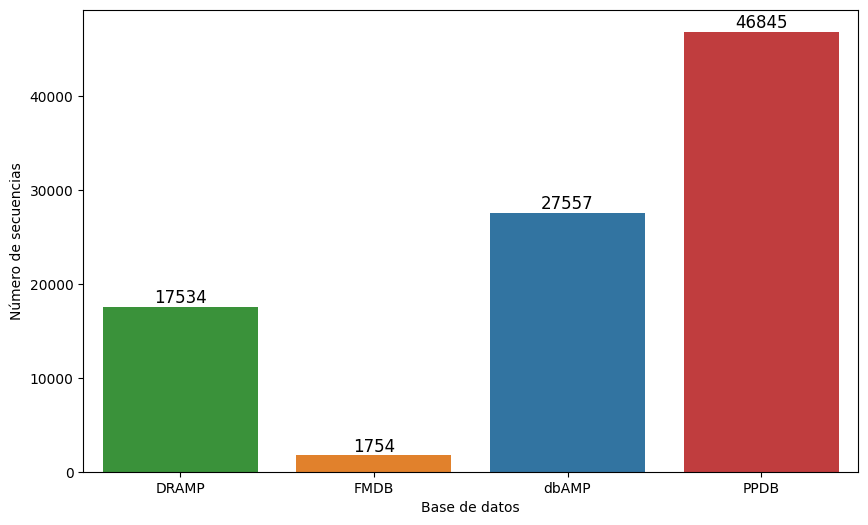

In [14]:

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Contar el número total de secuencias por base de datos
total_sequences_per_db = final_data.groupby('db_source').size()

# Calcular el total general de todas las secuencias
total_general = total_sequences_per_db.sum()

# Agregar el total general como una nueva categoría en los datos
total_sequences_per_db['PPDB'] = total_general


colors_bd = {
    'dbAMP': '#1f77b4',  # Azul
    'FMDB': '#ff7f0e',  # Naranja
    'DRAMP': '#2ca02c',  # Verde
    'PPDB': '#d62728',  # Rojo
}

# Graficar
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=total_sequences_per_db.index, y=total_sequences_per_db.values, palette=colors_bd)

# Añadir los números dentro de cada barra
for i, count in enumerate(total_sequences_per_db.values):
    barplot.text(i, count, str(count), ha='center', va='bottom', color='black', fontsize=12)

plt.title('')
plt.xlabel('Base de datos')
plt.ylabel('Número de secuencias')
plt.xticks(rotation=0)

plt.savefig('graph_plots/num_sec_por_bd_total.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\noral\AppData\Local\Temp\ipykernel_5080\1304308498.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=unique_counts.index, y=unique_counts.values, palette=colors_bd)


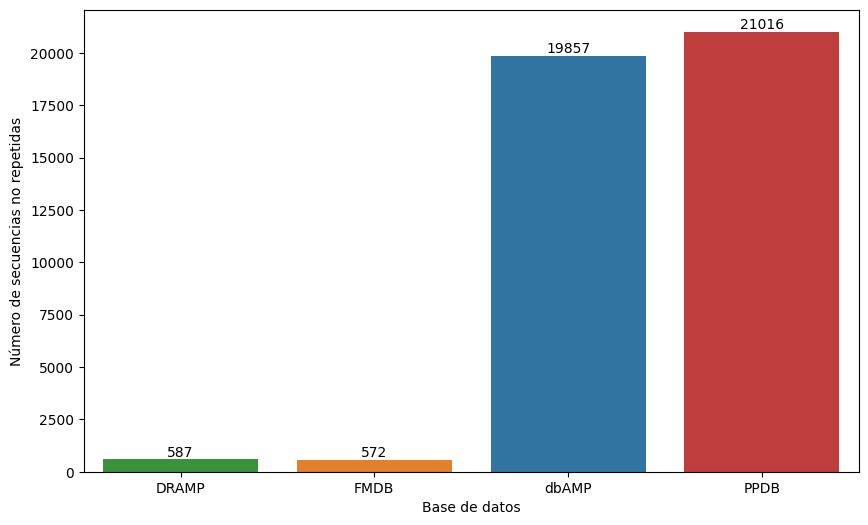

In [15]:
# Asegúrate de que 'sequence' sea considerada para la unicidad
unique_counts = final_data.drop_duplicates(subset=['sequence']).groupby('db_source').size()

# Calcular el total general de todas las secuencias únicas
total_unicas_general = unique_counts.sum()

# Agregar el total general como una nueva categoría en los datos
unique_counts['PPDB'] = total_unicas_general

# Graficar
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=unique_counts.index, y=unique_counts.values, palette=colors_bd)

# Añadir los números encima de cada barra
for i, count in enumerate(unique_counts.values):
    # Ajustar la posición del texto para que no se solape con el borde superior de la barra
    barplot.text(i, count + 5, str(count), ha='center', va='bottom')

plt.title('')
plt.xlabel('Base de datos')
plt.ylabel('Número de secuencias no repetidas')
plt.xticks()
plt.savefig('graph_plots/num_sec_unicas_por_bd_total.png', bbox_inches='tight', dpi=300)
plt.show()

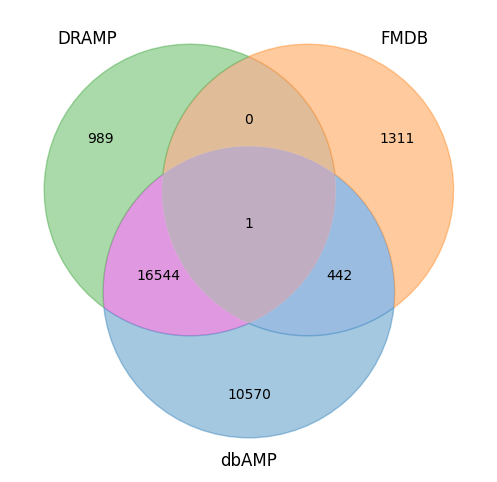

In [16]:

from matplotlib_venn import venn3_unweighted
import matplotlib.pyplot as plt

# Preparar datos para el gráfico de Venn
db1 = final_data[final_data['db_source'] == 'DRAMP'][['sequence']]
db2 = final_data[final_data['db_source'] == 'FMDB'][['sequence']]
db3 = final_data[final_data['db_source'] == 'dbAMP'][['sequence']]

# Convertir a listas para permitir conteo correcto
db1_list = db1['sequence'].tolist()
db2_list = db2['sequence'].tolist()
db3_list = db3['sequence'].tolist()


# Contar las secuencias en cada base de datos
db1_count = len(db1_list)
db2_count = len(db2_list)
db3_count = len(db3_list)

# Contar las intersecciones
db1_db2 = [seq for seq in db1_list if seq in db2_list]
db1_db3 = [seq for seq in db1_list if seq in db3_list]
db2_db3 = [seq for seq in db2_list if seq in db3_list]
db1_db2_db3 = [seq for seq in db1_db2 if seq in db3_list]

db1_db2_count = len(db1_db2)
db1_db3_count = len(db1_db3)
db2_db3_count = len(db2_db3)
db1_db2_db3_count = len(db1_db2_db3)

# Crear el gráfico de Venn con círculos de igual tamaño
plt.figure(figsize=(10, 6))
venn = venn3_unweighted(subsets=(db1_count - db1_db2_count - db1_db3_count + db1_db2_db3_count, 
                                 db2_count - db1_db2_count - db2_db3_count + db1_db2_db3_count, 
                                 db1_db2_count - db1_db2_db3_count, 
                                 db3_count - db1_db3_count - db2_db3_count + db1_db2_db3_count, 
                                 db1_db3_count - db1_db2_db3_count, 
                                 db2_db3_count - db1_db2_db3_count, 
                                 db1_db2_db3_count), 
                          set_labels=('DRAMP', 'FMDB', 'dbAMP'))

# Asignar colores manualmente
venn.get_patch_by_id('100').set_color(colors_bd['DRAMP'])
venn.get_patch_by_id('010').set_color(colors_bd['FMDB'])
venn.get_patch_by_id('001').set_color(colors_bd['dbAMP'])

plt.title('')
plt.savefig('graph_plots/venn_diagram_sec.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\noral\AppData\Local\Temp\ipykernel_5080\2200735732.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counts = counts.fillna(0)


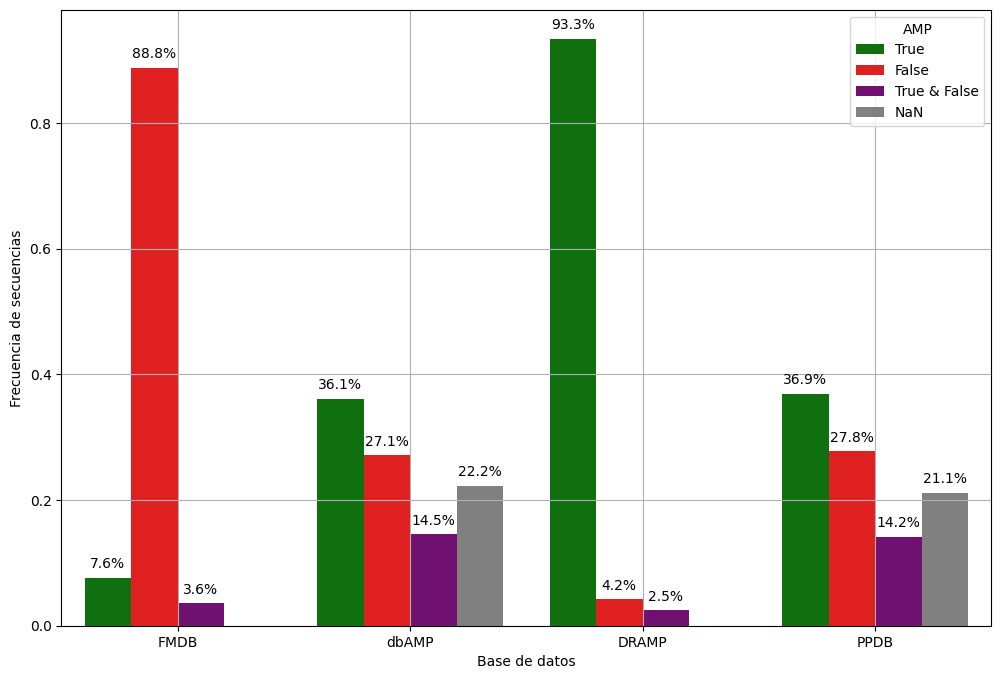

In [17]:

# Crear un DataFrame para almacenar los conteos
counts = pd.DataFrame(index=final_data['db_source'].unique().tolist() + ['PPDB'], columns=['True', 'False', 'True_False', 'NaN'])

# Contar las secuencias por cada combinación de valores en AMP para cada base de datos y el total
for db_source in final_data['db_source'].unique().tolist() + ['PPDB']:
    if db_source == 'PPDB':
        subset = final_data
    else:
        subset = final_data[final_data['db_source'] == db_source]
    
    true_counts = subset[subset['AMP'] == True]['sequence'].nunique()
    false_counts = subset[subset['AMP'] == False]['sequence'].nunique()
    
    sequences_with_true = subset[subset['AMP'] == True]['sequence'].unique()
    sequences_with_false = subset[subset['AMP'] == False]['sequence'].unique()
    true_false_counts = len(set(sequences_with_true) & set(sequences_with_false))
    
    nan_counts = subset[subset['AMP'].isna()]['sequence'].nunique()
    
    # Calcular el total de secuencias únicas para la normalización
    total_sequences = true_counts + false_counts + true_false_counts + nan_counts
    
    # Actualizar conteos con frecuencias (conteo / total de secuencias)
    counts.at[db_source, 'True'] = true_counts / total_sequences if total_sequences > 0 else 0
    counts.at[db_source, 'False'] = false_counts / total_sequences if total_sequences > 0 else 0
    counts.at[db_source, 'True_False'] = true_false_counts / total_sequences if total_sequences > 0 else 0
    counts.at[db_source, 'NaN'] = nan_counts / total_sequences if total_sequences > 0 else 0

# Reemplazar NaN en el DataFrame con 0 donde no haya valores
counts = counts.fillna(0)

# Crear el DataFrame para graficar
counts = counts.reset_index().melt(id_vars='index', value_vars=['True', 'False', 'True_False', 'NaN'], 
                                   var_name='AMP', value_name='Frequency')

# Renombrar la columna 'index' a 'db_source'
counts.rename(columns={'index': 'db_source'}, inplace=True)

# Definir una paleta de colores específica para los valores
palette = {'True': 'green', 'False': 'red', 'True_False': 'purple', 'NaN': 'grey'}

# Graficar
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='db_source', y='Frequency', hue='AMP', data=counts, palette=palette, dodge=True)

# Añadir los números dentro de cada barra
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Solo colocar etiqueta si la altura es mayor a cero para evitar desorden en la gráfica
        barplot.annotate(f'{height:.1%}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 10), 
                         textcoords = 'offset points')

plt.title('')
plt.xlabel('Base de datos')
plt.ylabel('Frecuencia de secuencias')
plt.xticks()
handles, labels = barplot.get_legend_handles_labels()
plt.legend(handles, ['True', 'False', 'True & False', 'NaN'], title='AMP')
plt.grid()
plt.savefig('graph_plots/AMP_by_db.png', bbox_inches='tight', dpi=300)
plt.show()

C:\Users\noral\AppData\Local\Temp\ipykernel_5080\4050443723.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=activities_per_db.index, y=activities_per_db.values, palette=colors_bd)


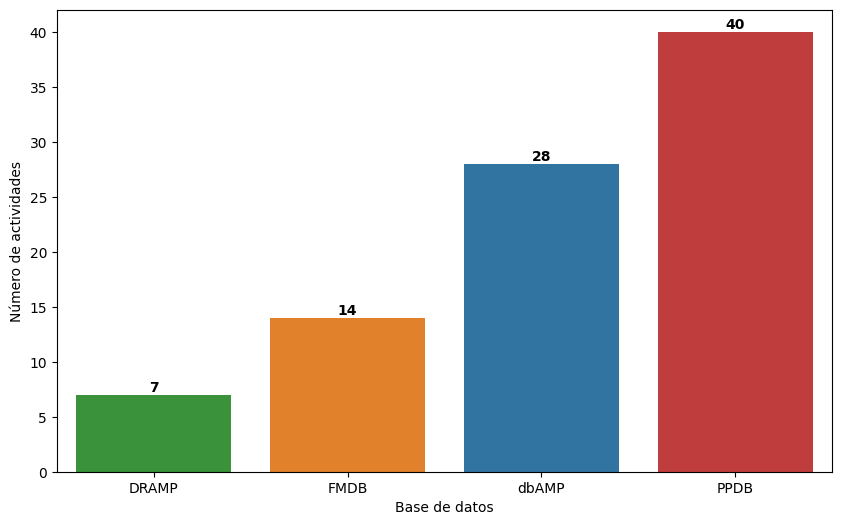

In [18]:

# Contar el número de actividades únicas por base de datos
activities_per_db = final_data.groupby('db_source')['Activity'].nunique()

# Calcular el número total de actividades únicas en todo el dataset
total_activities = final_data['Activity'].nunique()

# Agregar este total al objeto Series existente
activities_per_db['PPDB'] = total_activities

# Graficar
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=activities_per_db.index, y=activities_per_db.values, palette=colors_bd)

# Añadir los números dentro de cada barra
for i, value in enumerate(activities_per_db.values):
    barplot.text(i, value, str(value), color='black', ha='center', va='bottom', fontsize=10, weight='bold')

plt.title('')
plt.xlabel('Base de datos')
plt.ylabel('Número de actividades')
plt.xticks()

plt.savefig('graph_plots/actividades_unic_por_bd_total.png', bbox_inches='tight', dpi=300)
plt.show()

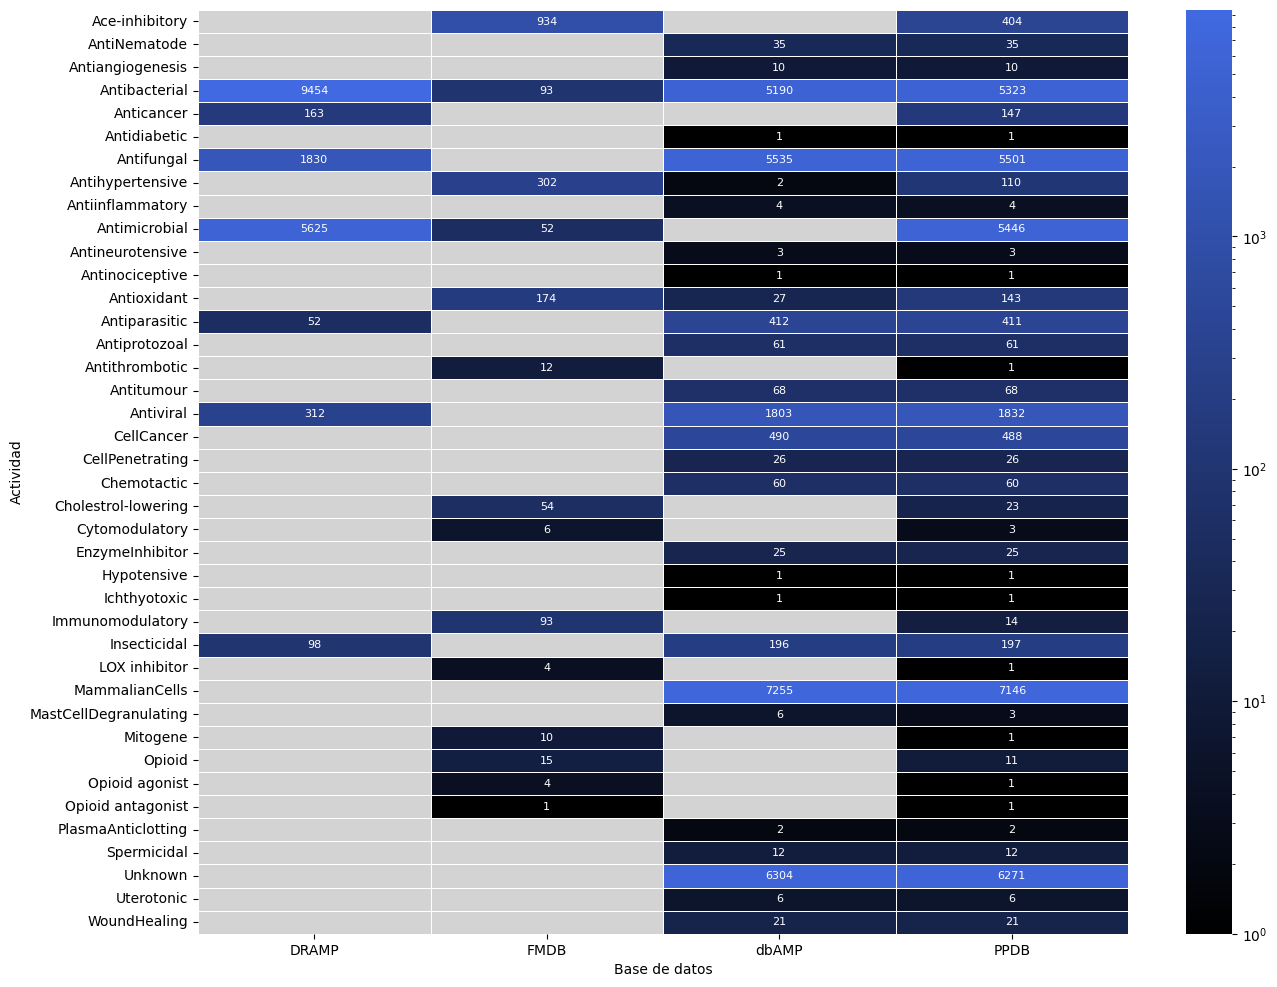

In [19]:

from matplotlib.colors import LinearSegmentedColormap, LogNorm

# Crear una tabla de frecuencia cruzada de secuencias por db_source y Activity
heatmap_data = pd.crosstab(final_data['Activity'], final_data['db_source'])

# Calcular la frecuencia total de secuencias por Activity
total_counts = final_data.groupby('Activity')['sequence'].nunique()

# Añadir los totales a la tabla de frecuencia cruzada
heatmap_data['PPDB'] = total_counts

# Crear una paleta personalizada que vaya de negro a verde
cmap = LinearSegmentedColormap.from_list('black_to_green', ['black', 'royalblue'])

# Crear una máscara para los valores cero
mask = heatmap_data == 0

# Configurar la figura y el tamaño del gráfico
plt.figure(figsize=(15, 12))

# Graficar
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap=cmap, norm=LogNorm(vmin=1, vmax=heatmap_data.values.max()), 
            annot_kws={"size": 8, "color": "white"}, linecolor='white', linewidths=0.5, mask=mask, cbar_kws={'ticks': [1, 10, 100, 1000, 10000]})

# Añadir un color gris claro para las celdas con valor cero
sns.heatmap(heatmap_data, mask=~mask, cbar=False, annot=False, fmt="d", cmap=LinearSegmentedColormap.from_list('grey_only', ['lightgrey', 'lightgrey']), 
            linecolor='white', linewidths=0.5)

plt.title('')
plt.xlabel('Base de datos')
plt.ylabel('Actividad')
plt.xticks(rotation=0)
plt.yticks(rotation=0)  # Para mantener las etiquetas de actividad legibles

plt.savefig('graph_plots/heatmap_num_sec_por_acti_por_bd_total.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:
# Lista de features a analizar
features = [
    'length', 'charge', 'chargedensity', 'formulaC', 'formulaH', 'formulaN', 
    'formulaO', 'formulaS', 'tot', 'hydrogen', 'single', 'double', 'MW_modlamp',
    'Gravy', 'Aromacity', 'IsoelectricPoint', 'Instability_index',
    'SecStruct_helix', 'SecStruct_turn', 'SecStruct_sheet',
    'Molar_extinction_coefficient_reduced',
    'Molar_extinction_coefficient_oxidized', 'aliphatic_index', 'bomanindex', 
    'hydrophobic_ratio', 'A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 
    'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'hydrophobic_freq', 
    'hydrophilic_freq', 'basic_freq', 'acid_freq'
]

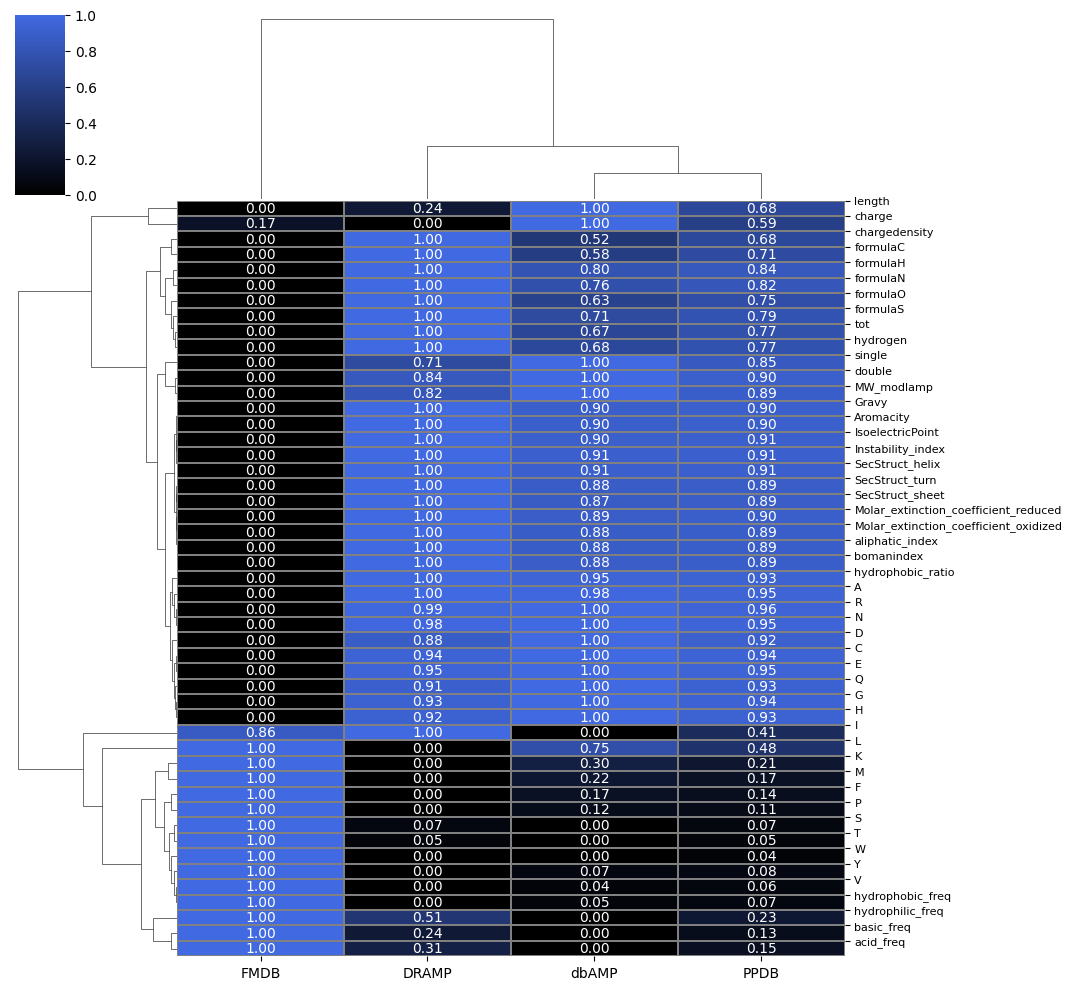

In [21]:
import matplotlib.colors as mcolors


# Calcular las medias agrupadas por 'db_source'
mean_values = final_data.groupby('db_source')[features].mean()

# Calcular las medias totales para todo el conjunto de datos
total_mean_values = final_data[features].mean()
total_mean_values.name = 'PPDB'

# Añadir las medias totales al DataFrame de medias
mean_values = pd.concat([mean_values, total_mean_values.to_frame().T])

# Normalizar los datos por columnas (features)
normalized_data = mean_values.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Crear una colormap personalizada de blanco a rojo
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["black", "royalblue"])

# Crear un clustermap de las medias normalizadas con márgenes en blanco
clustermap = sns.clustermap(normalized_data.T, cmap=cmap, annot=True, fmt='.2f', linewidths=0.1, linecolor='grey', method='average', metric='euclidean')

# Asegurar que todos los ticks de las variables aparezcan
clustermap.ax_heatmap.set_yticks(range(len(normalized_data.columns)))
clustermap.ax_heatmap.set_yticklabels(normalized_data.columns)

# Ajustar el tamaño de la letra de los labels del eje y
for label in clustermap.ax_heatmap.get_yticklabels():
    label.set_size(8)  

# Ajustar los ticks de las variables para que todos aparezcan
plt.setp(clustermap.ax_heatmap.get_xticklabels(), rotation=0)
plt.setp(clustermap.ax_heatmap.get_yticklabels(), rotation=0)

clustermap.fig.suptitle('', y=1.02)

# Guardar el clustermap
clustermap.savefig('graph_plots/heatmap_features_normalized_por_bd_total_clustermap.png', bbox_inches='tight', dpi=300)
plt.show()

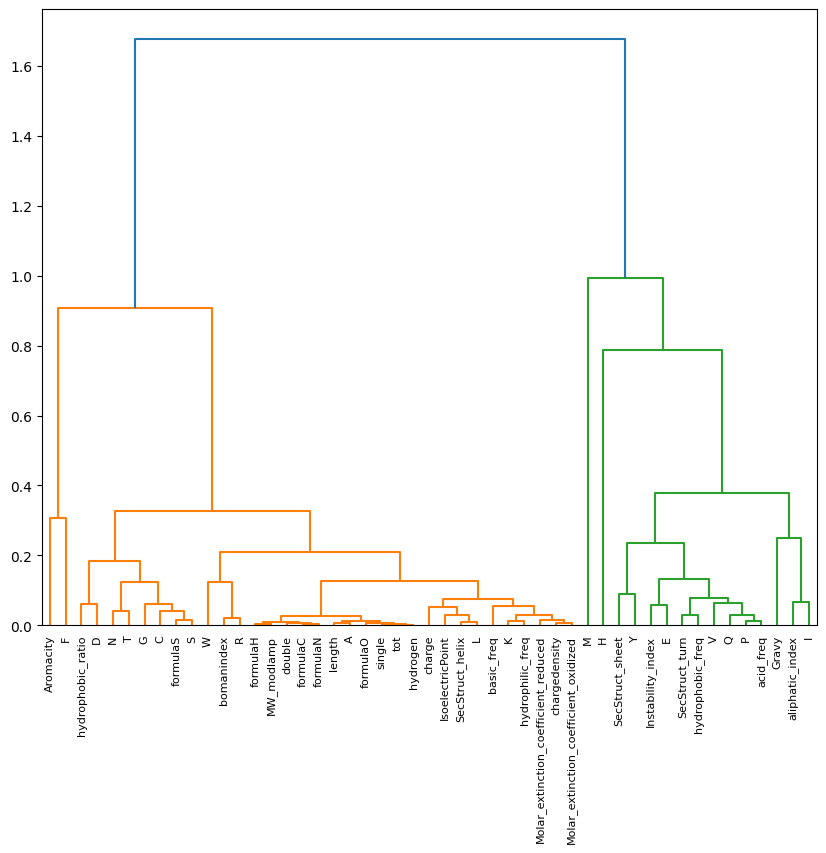

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

# Calcular las medias agrupadas por 'db_source'
mean_values = final_data.groupby('db_source')[features].mean()

# Calcular las medias totales para todo el conjunto de datos
total_mean_values = final_data[features].mean()
total_mean_values.name = 'PPDB'

# Añadir las medias totales al DataFrame de medias
mean_values = pd.concat([mean_values, total_mean_values.to_frame().T])

# Normalizar los datos por columnas (features)
normalized_data = mean_values.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Generar un dendrograma para las variables (columnas)
linked = linkage(normalized_data.T, method='average')

# Crear el dendrograma
plt.figure(figsize=(10, 8))
dendrogram(linked, labels=normalized_data.columns, leaf_rotation=90)
plt.title('')
plt.savefig('graph_plots/dendrograma_FQ.png')


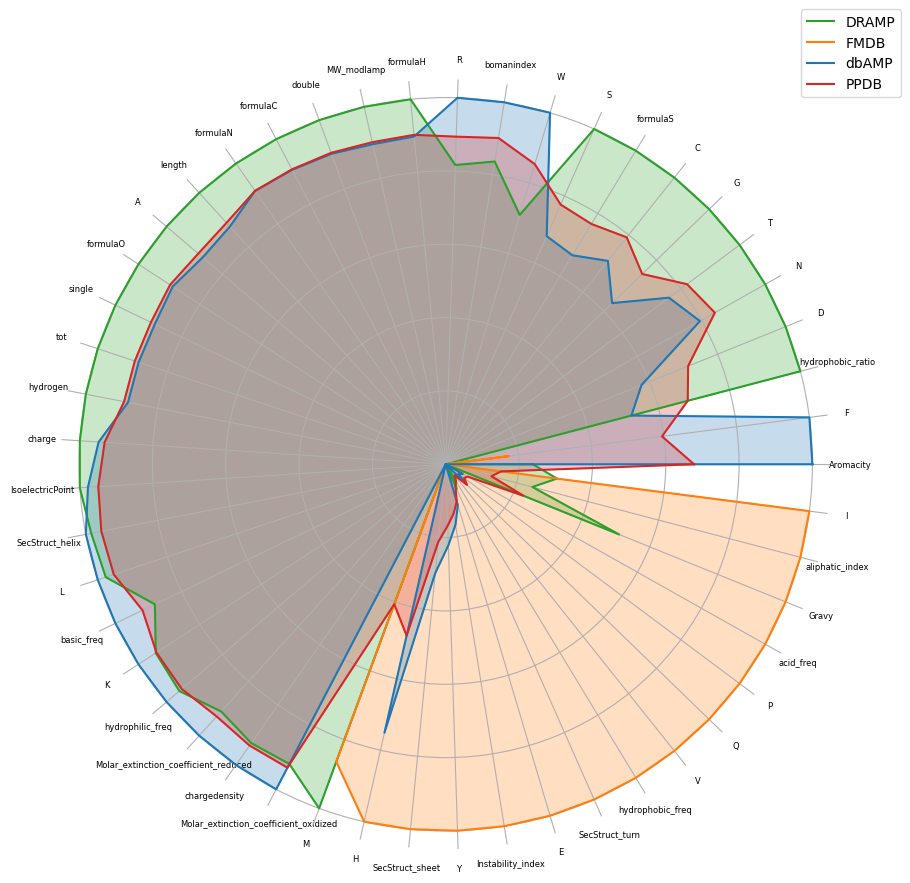

In [23]:
# Reordenar las columnas según el dendrograma
order = leaves_list(linked)
ordered_columns = normalized_data.columns[order]
ordered_data = normalized_data[ordered_columns]

# Configurar el radar chart
categories = list(ordered_data.columns)
num_vars = len(categories)

# Función para crear el radar chart
def create_radar_chart(data, title):
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for idx, row in data.iterrows():
        if idx in colors_bd: 
            values = row.values.flatten().tolist()
            values += values[:1]  # Cerrar el círculo
            ax.plot(angles, values, label=idx, color=colors_bd[idx])
            ax.fill(angles, values, color=colors_bd[idx], alpha=0.25)
        else:
            print(f"Advertencia: No hay color asignado para {idx}")

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=6, rotation=45)
    ax.spines['polar'].set_visible(False)  # Eliminar los ejes polares

    plt.title(title, size=15, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.savefig('graph_plots/radar_chart.png')  # Guardar la figura
    plt.show()

# Crear el radar chart con los datos ordenados y etiquetas rotadas
create_radar_chart(ordered_data, '')

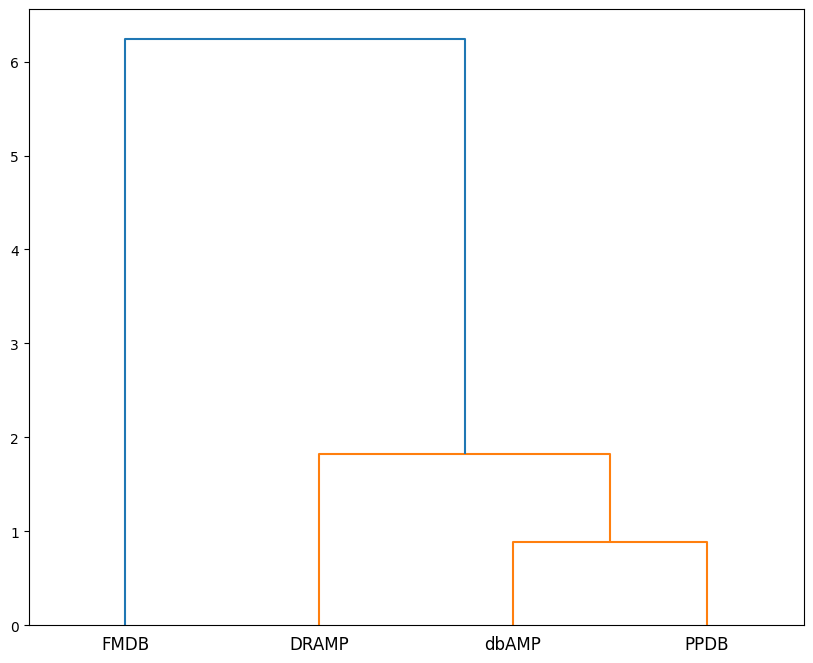

In [24]:
# Calcular las medias agrupadas por 'db_source'
mean_values = final_data.groupby('db_source')[features].mean()

# Calcular las medias totales para todo el conjunto de datos
total_mean_values = final_data[features].mean()
total_mean_values.name = 'PPDB'

# Añadir las medias totales al DataFrame de medias
mean_values = pd.concat([mean_values, total_mean_values.to_frame().T])

# Normalizar los datos por propiedades
normalized_data = mean_values.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Generar un dendrograma para las bases de datos
linked = linkage(normalized_data, method='average')

# Crear el dendrograma
plt.figure(figsize=(10, 8))
dendrogram(linked, labels=normalized_data.index, leaf_rotation=0)
plt.title('')
plt.savefig('graph_plots/dendrograma_db.png') 
plt.show()

In [25]:
from PIL import Image

# Cargar las imágenes
radar_chart_image = Image.open('graph_plots/radar_chart.png')
dendrogram_features_image = Image.open('graph_plots/dendrograma_FQ.png')
dendrogram_databases_image = Image.open('graph_plots/dendrograma_db.png')

# Redimensionar las imágenes de los dendrogramas para que sean del mismo tamaño
dendrogram_features_image = dendrogram_features_image.resize((dendrogram_features_image.width, radar_chart_image.height // 2))
dendrogram_databases_image = dendrogram_databases_image.resize((dendrogram_databases_image.width, radar_chart_image.height // 2))

# Determinar el tamaño de la nueva imagen
width = radar_chart_image.width + dendrogram_features_image.width
height = radar_chart_image.height

# Crear una nueva imagen en blanco
combined_image = Image.new('RGB', (width, height))

# Pegar el radar chart a la izquierda
combined_image.paste(radar_chart_image, (0, 0))

# Pegar los dendrogramas a la derecha
combined_image.paste(dendrogram_features_image, (radar_chart_image.width, 0))
combined_image.paste(dendrogram_databases_image, (radar_chart_image.width, dendrogram_features_image.height))

# Guardar la imagen combinada
combined_image.save('graph_plots/combined_image.png')
combined_image.show()

### PCA

PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad que transforma los datos a un nuevo sistema de coordenadas donde las variables están ordenadas por su varianza. Es conveniente usarlo porque simplifica los datos, reduce el ruido y ayuda a identificar las características más importantes, facilitando el análisis y la visualización.

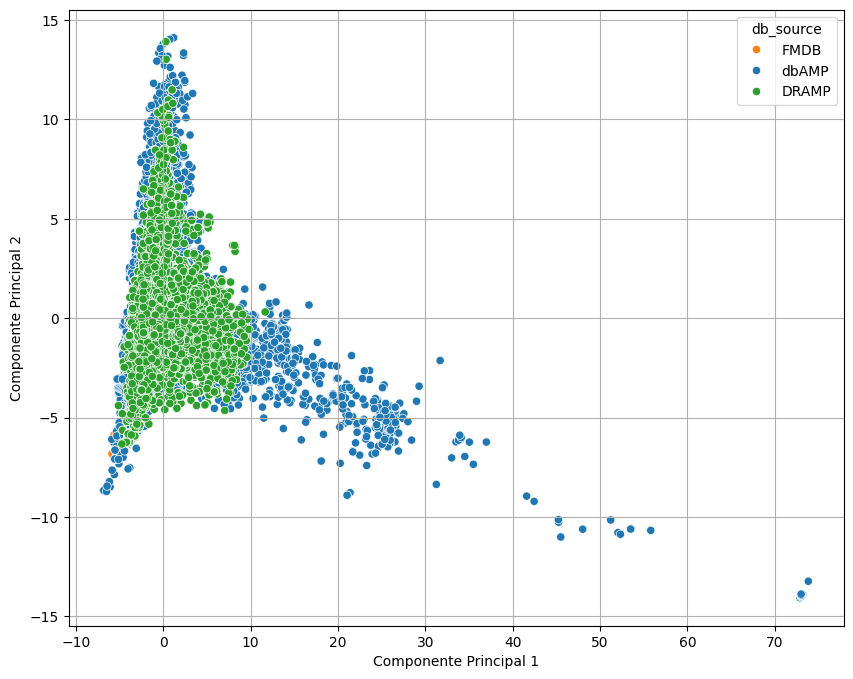

In [26]:

# Verificar que todas las características son numéricas
df_features = final_data[features].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN
df_features = df_features.dropna()

# Escalar los datos
scaler = StandardScaler()
x = scaler.fit_transform(df_features)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['db_source'] = data.loc[df_features.index, 'db_source']

# Graficar PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='db_source', data=pca_df, palette=colors_bd)
plt.title('')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()

plt.savefig('graph_plots/pca_por_bd.png', bbox_inches='tight', dpi=300)
plt.show()

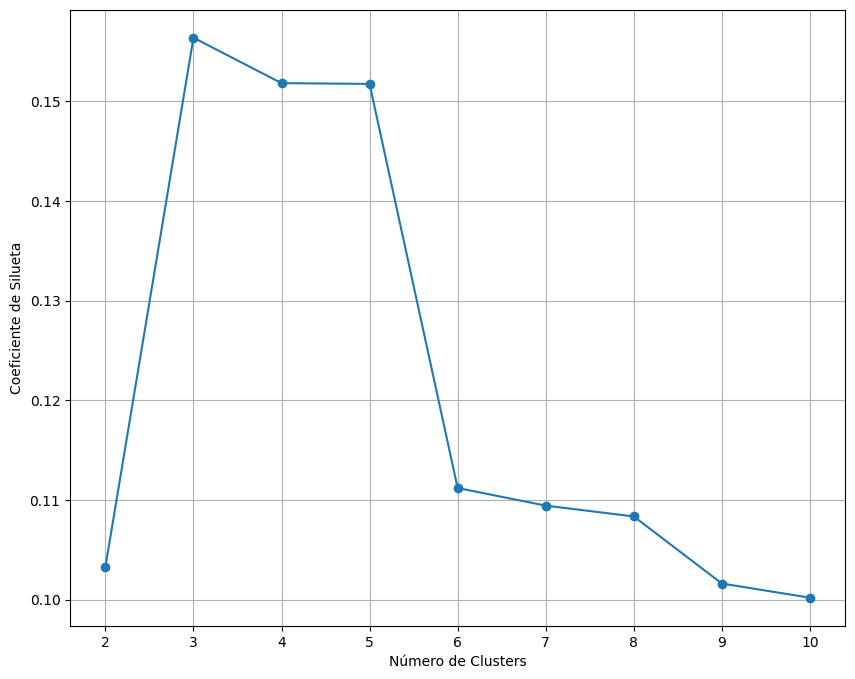

In [27]:
#Método del Codo
sse = []
k_range = range(1, 11)

from sklearn.metrics import silhouette_score

# Método de la Silueta
silhouette_scores = []

for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x)
    silhouette_scores.append(silhouette_score(x, labels))

plt.figure(figsize=(10, 8))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('')
plt.grid()

plt.savefig('graph_plots/silueta.png', bbox_inches='tight', dpi=300)
plt.show()

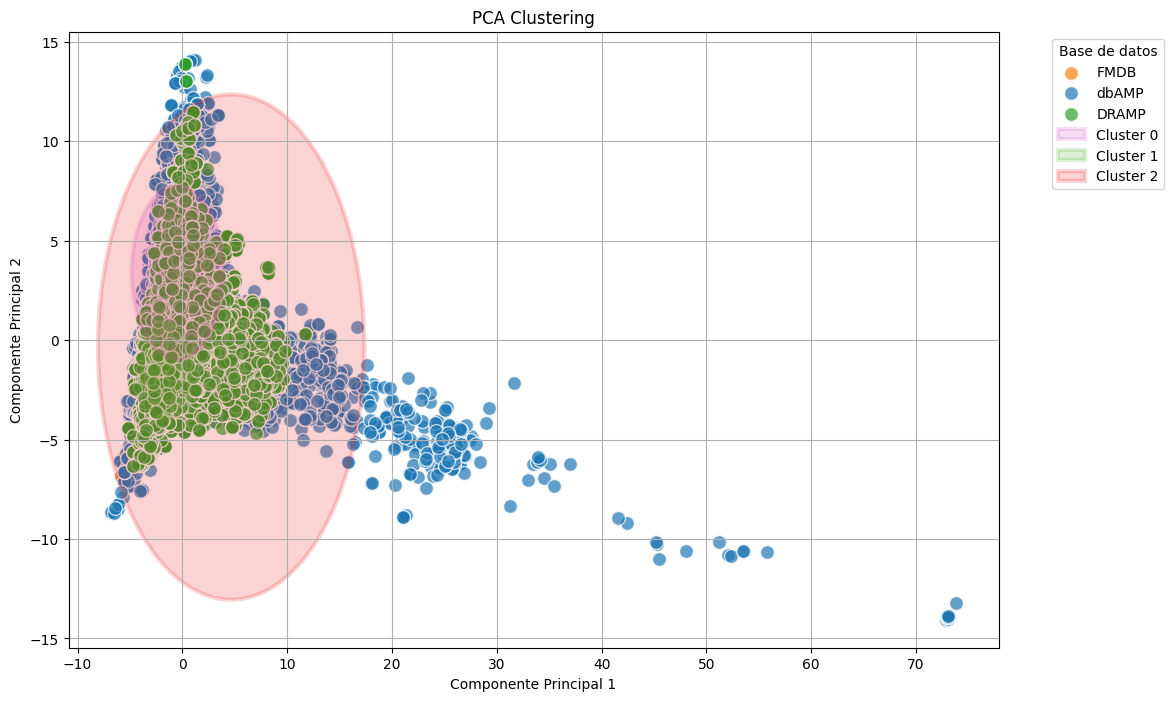

In [28]:
colors = {
    'dbAMP': '#1f77b4',  # Azul
    'FMDB': '#ff7f0e',  # Naranja
    'DRAMP': '#2ca02c'  # Verde
}

# Clusterización con K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(x)
pca_df['Cluster'] = clusters

# Definir colores para los clusters
colors_clusters = ['#da5dcf', '#4db42f', '#f02323']

# Graficar PCA usando solo esferas para cada db_source
plt.figure(figsize=(12, 8))

for db_source in pca_df['db_source'].unique():
    subset = pca_df[pca_df['db_source'] == db_source]
    plt.scatter(subset['PC1'], subset['PC2'], marker='o', color=colors[db_source], label=db_source, alpha=0.7, edgecolors='w', s=100)

# Añadir círculos alrededor de cada cluster
for i in range(len(kmeans.cluster_centers_)):
    cluster_points = pca_df[pca_df['Cluster'] == i]
    centroid = kmeans.cluster_centers_[i]
    centroid_pca = pca.transform([centroid])[0]
    radius = np.max(np.sqrt(np.sum((cluster_points[['PC1', 'PC2']] - centroid_pca) ** 1.2, axis=1)))
    circle = plt.Circle((centroid_pca[0], centroid_pca[1]), radius, color=colors_clusters[i], fill=True, alpha=0.2, linewidth=3, linestyle='-', label=f'Cluster {i}')
    plt.gca().add_artist(circle)

plt.title('PCA Clustering')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Base de datos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.savefig('graph_plots/pca_por_bd_cluster.png', bbox_inches='tight', dpi=300)
plt.show()


### UMAP

UMAP (Uniform Manifold Approximation and Projection) es una técnica de reducción de dimensionalidad que preserva tanto la estructura local como global de los datos. Es conveniente usarlo porque es eficiente en tiempo de ejecución, maneja grandes volúmenes de datos y proporciona visualizaciones claras y útiles en espacios de baja dimensión.

c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:427: UserWarning: Exited at iteration 2000 with accuracies 
[5.88690375e-15 8.83698266e-07 6.66519441e-07 6.34787028e-06
 1.65984110e-05]
not reaching the requested tolerance 3.3676624298095703e-06.
Use iteration 1288 instead with accuracy 
1.3475133924523479e-06.

  _, diffusion_map = lobpcg(
c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:427: UserWarning: Exited postprocessing with accuracies 
[2.70825023e-15 9.72096547e-07 4.87238015e-07 1.23302894e-06
 4.04519937e-06]
not reaching the requested tolerance 3.367662

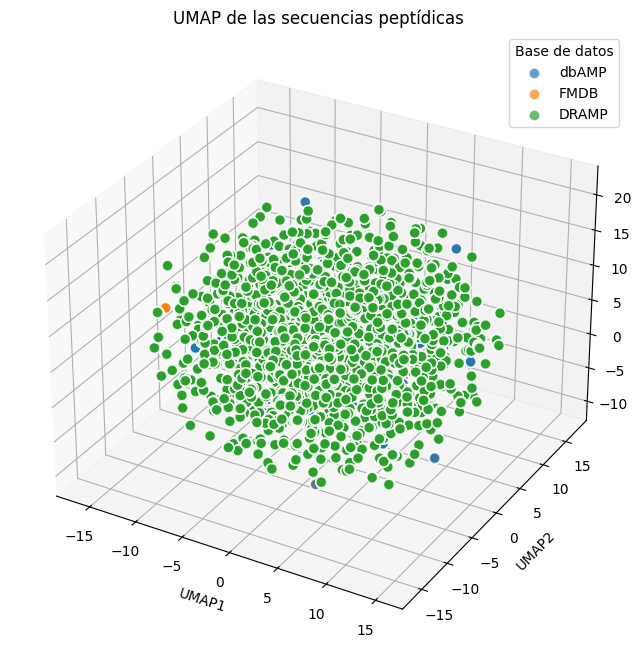

In [29]:
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D

# Verificar que todas las características son numéricas
df_features = final_data[features].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores NaN
df_features = df_features.dropna()

# Escalar los datos
scaler = StandardScaler()
x = scaler.fit_transform(df_features)

# UMAP con 3 componentes
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_components = umap_model.fit_transform(x)
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['db_source'] = final_data.loc[df_features.index, 'db_source']

# Asignar colores según la base de datos
umap_df['color'] = umap_df['db_source'].map(colors)

# Graficar UMAP en 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for db_source in colors:
    subset = umap_df[umap_df['db_source'] == db_source]
    ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'], label=db_source, color=colors[db_source], s=60, alpha=0.7, edgecolors='w')

ax.set_title('UMAP de las secuencias peptídicas')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Crear la leyenda manualmente
ax.legend(title="Base de datos")

plt.grid()
plt.savefig('graph_plots/umap_por_bd_cluster.png', bbox_inches='tight', dpi=300)

plt.show()

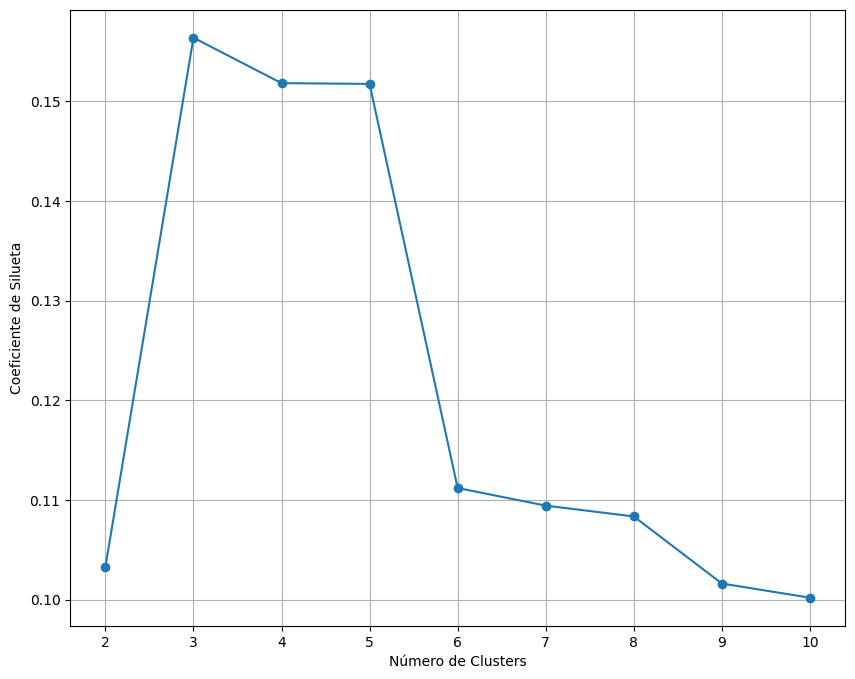

In [30]:
# Método del Codo 
sse = []
k_range = range(1, 11)

# Método de la Silueta 
silhouette_scores = []

for k in k_range[1:]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(x)
    silhouette_scores.append(silhouette_score(x, labels))

plt.figure(figsize=(10, 8))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('')
plt.grid()

plt.savefig('graph_plots/silueta.png', bbox_inches='tight', dpi=300)
plt.show()

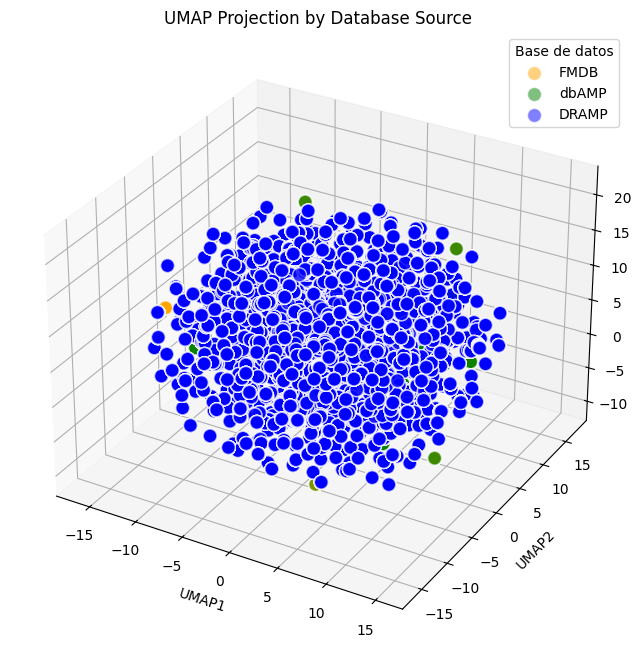

In [31]:
# Clusterización con K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(x)
umap_df['Cluster'] = clusters

# Graficar UMAP en 3D usando solo esferas para cada db_source
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['orange', 'green', 'blue']  # Puedes ajustar estos colores si lo deseas

for i, db_source in enumerate(umap_df['db_source'].unique()):
    subset = umap_df[umap_df['db_source'] == db_source]
    ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'], marker='o', label=db_source, color=colors[i], alpha=0.5, edgecolors='w', s=100)

# Añadir la leyenda manualmente
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Base de datos')

plt.title('UMAP Projection by Database Source')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.grid()

plt.savefig('graph_plots/umap_por_bd_cluster_3d.png', bbox_inches='tight', dpi=300)
plt.show()


c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:427: UserWarning: Exited at iteration 2000 with accuracies 
[3.20838866e-15 8.90773555e-07 8.63248311e-07 9.18361738e-06]
not reaching the requested tolerance 3.3676624298095703e-06.
Use iteration 1901 instead with accuracy 
1.7899234078562892e-06.

  _, diffusion_map = lobpcg(
c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:427: UserWarning: Exited postprocessing with accuracies 
[4.01644781e-15 8.52820572e-07 7.30527975e-07 5.57635815e-06]
not reaching the requested tolerance 3.3676624298095703e-06.
  _, diffusion_m

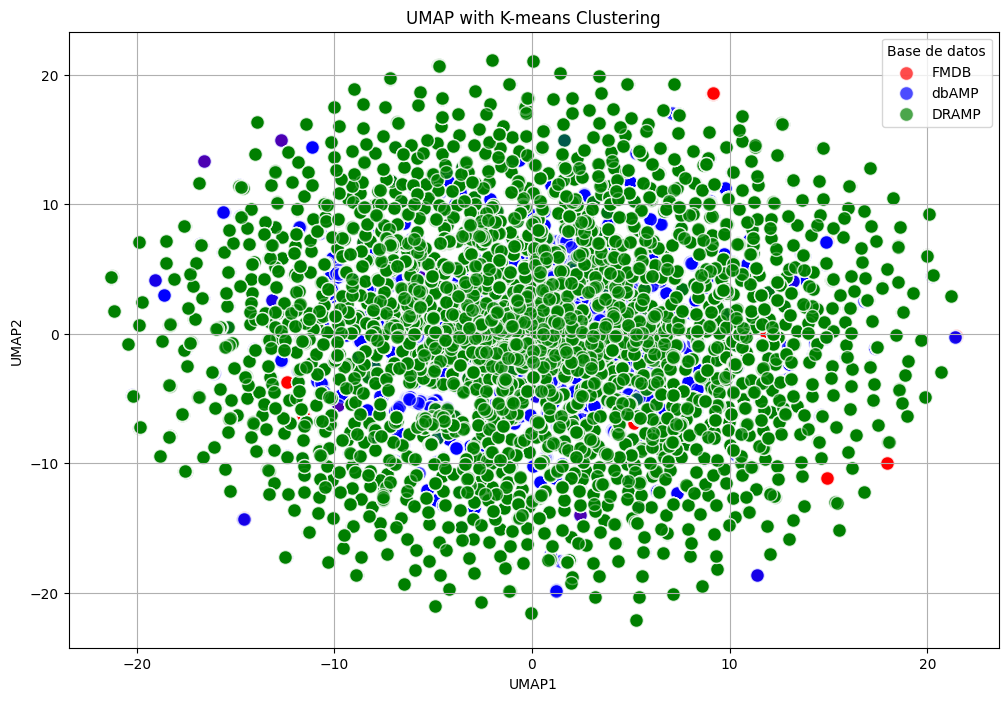

In [32]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


def print_umap(data, db_source, n_components=2, cluster=True):
    # Asegurarse de que los datos sean numpy array
    if isinstance(data, torch.Tensor):
        data = data.numpy()
        
    # Reducir dimensionalidad con UMAP
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    umap_data = reducer.fit_transform(data)

    # Convertir UMAP a DataFrame
    umap_df = pd.DataFrame(data=umap_data, columns=[f'UMAP{i+1}' for i in range(n_components)])
    umap_df['db_source'] = db_source

    if cluster:
        # Clusterización con K-means
        kmeans = KMeans(n_clusters=3, random_state=42)
        clusters = kmeans.fit_predict(data)
        umap_df['Cluster'] = clusters

        # Graficar UMAP en 2D con clusterización
        plt.figure(figsize=(12, 8))
        colors = ['red', 'blue', 'green']  # Definir colores para cada db_source

        for db_source, color in zip(umap_df['db_source'].unique(), colors):
            subset = umap_df[umap_df['db_source'] == db_source]
            plt.scatter(subset['UMAP1'], subset['UMAP2'], label=db_source, color=color, alpha=0.7, edgecolors='w', s=100)

        plt.legend(title='Base de datos')
        plt.title('UMAP with K-means Clustering')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid()
        plt.show()
    else:
        # Graficar UMAP en 2D sin clusterización
        plt.figure(figsize=(12, 8))
        plt.scatter(umap_data[:, 0], umap_data[:, 1], color="lightblue", s=10)
        plt.title('UMAP without Clustering')
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.grid()
        plt.show()

# Preparar y escalar los datos
df_features = final_data[features].apply(pd.to_numeric, errors='coerce').dropna()
scaler = StandardScaler()
x = scaler.fit_transform(df_features)

# Usar la función `print_umap`
db_source = final_data.loc[df_features.index, 'db_source']
print_umap(torch.tensor(x), db_source, n_components=2, cluster=True)



### Tomando una muestra de la base de datos

Dado que no tenemos el mismo numero de secuencias para cada una de las bases de datos, realizaremos el PCA y el UMAP con un máximo de secuencias para cada base de datos, balanceando de esta forma el análisis y evitando sesgos.

C:\Users\noral\AppData\Local\Temp\ipykernel_5080\2292563627.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_data = db_groups.apply(lambda x: x.sample(min_size)).reset_index(drop=True)


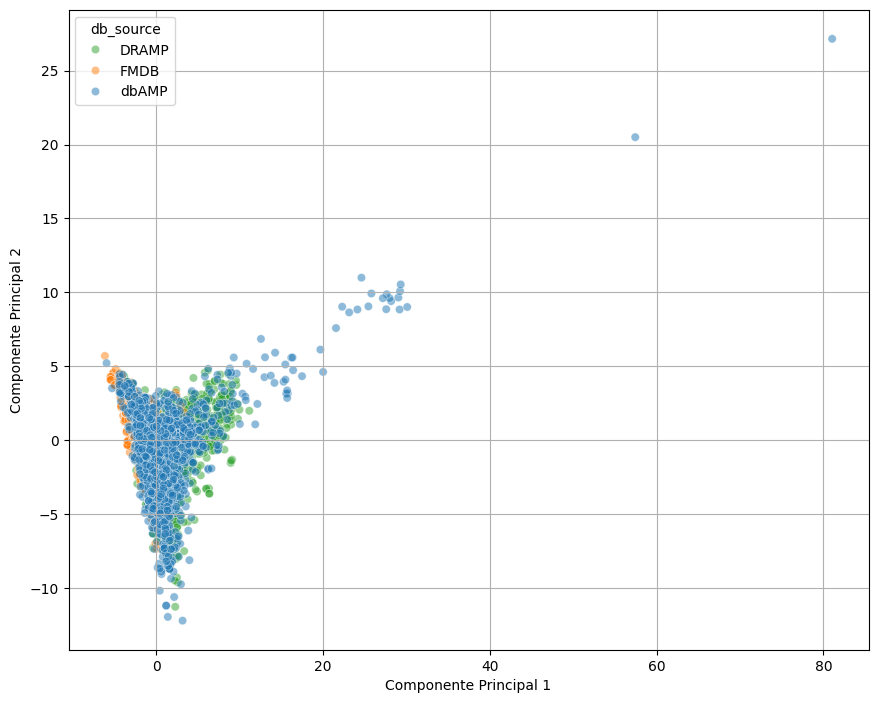

In [33]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap.umap_ as umap

colors = {
    'dbAMP': '#1f77b4',  # Azul
    'FMDB': '#ff7f0e',  # Naranja
    'DRAMP': '#2ca02c'
}

# Dividir los datos por base de datos
db_groups = final_data.groupby('db_source')

# Obtener el tamaño mínimo entre las bases de datos
min_size = db_groups.size().min()

# Submuestrear las bases de datos grandes
subsampled_data = db_groups.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

# Verificar que todas las características son numéricas y eliminar filas con NaN
df_features = subsampled_data[features].apply(pd.to_numeric, errors='coerce').dropna()

# Escalar los datos
scaler = StandardScaler()
x = scaler.fit_transform(df_features)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Graficar PCA con transparencia ajustada
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='db_source', data=pca_df, alpha=0.5, palette=colors)
plt.title('')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.grid()
plt.savefig('graph_plots/pca_por_bd_subsampled.png', bbox_inches='tight', dpi=300)
plt.show()

c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


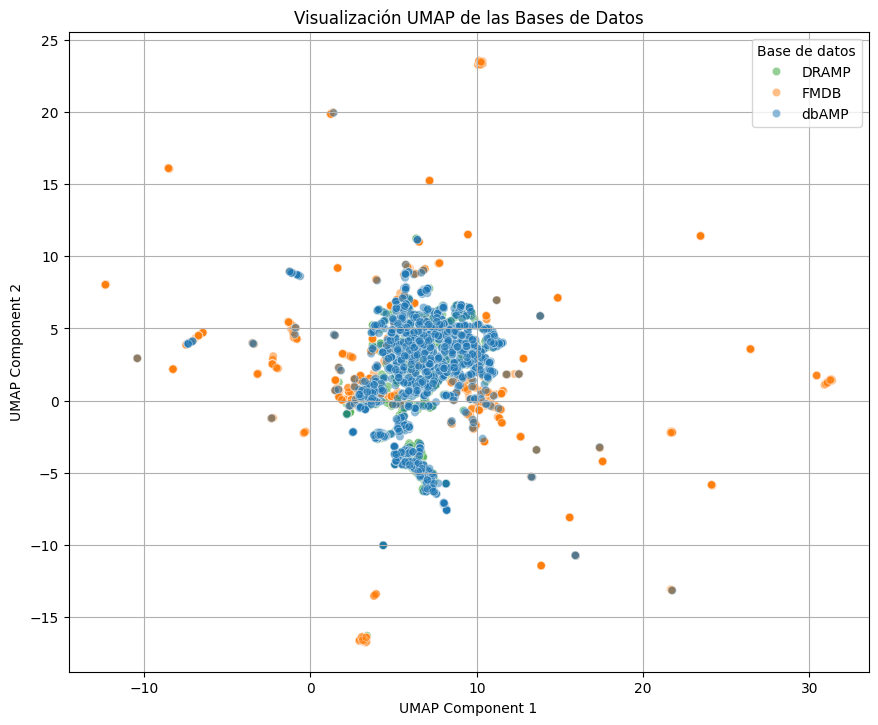

In [34]:
# UMAP con 2 componentes
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_components = umap_model.fit_transform(x)
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2'])
umap_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Graficar UMAP con transparencia ajustada
plt.figure(figsize=(10, 8))
plot = sns.scatterplot(x='UMAP1', y='UMAP2', hue='db_source', data=umap_df, alpha=0.5, palette=colors)
plt.title('Visualización UMAP de las Bases de Datos')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Ajustar y cambiar el título de la leyenda
plt.legend(title='Base de datos')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.grid()
plt.savefig('graph_plots/umap_por_bd_subsampled.png', bbox_inches='tight', dpi=300)
plt.show()

#### 3D 

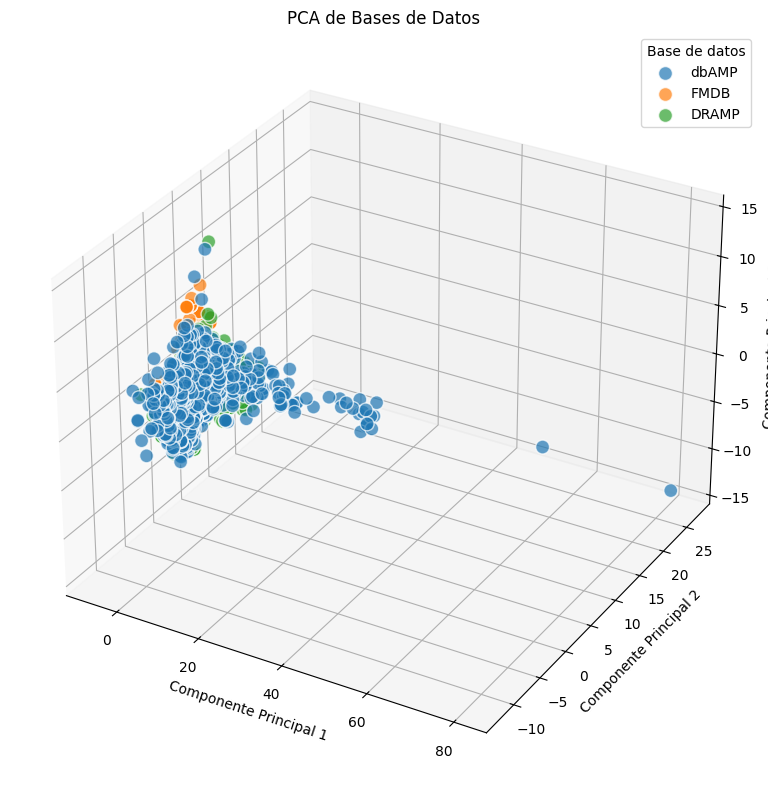

In [35]:
import plotly.express as px

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Graficar PCA en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for db_source, color in colors.items():
    subset = pca_df[pca_df['db_source'] == db_source]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=db_source, color=color, alpha=0.7, edgecolors='w', s=100)

ax.set_title('PCA de Bases de Datos')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.legend(title='Base de datos')

plt.tight_layout()
plt.grid()
plt.savefig('graph_plots/pca_por_bd_subsampled_3D.png', bbox_inches='tight', dpi=300)
plt.show()

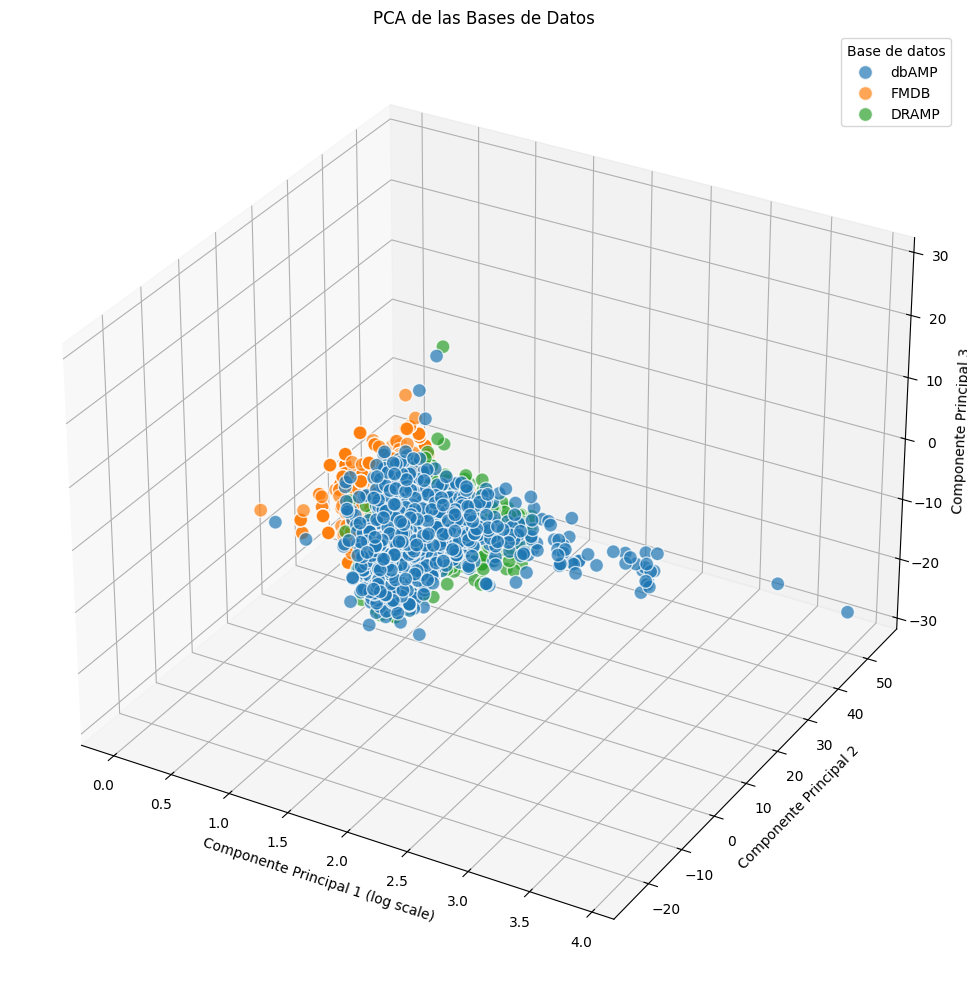

In [36]:

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Transformar el Componente Principal 1 a escala logarítmica
pca_df['PC1_log'] = np.log10(pca_df['PC1'] - pca_df['PC1'].min() + 1)

# Aplicar un escalado diferente para mejorar la separación
scale_factor = 2
pca_df['PC1_scaled'] = pca_df['PC1_log'] * scale_factor
pca_df['PC2_scaled'] = pca_df['PC2'] * scale_factor
pca_df['PC3_scaled'] = pca_df['PC3'] * scale_factor

# Graficar PCA en 3D con escala logarítmica en el eje del Componente Principal 1
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for db_source, color in colors.items():
    subset = pca_df[pca_df['db_source'] == db_source]
    ax.scatter(subset['PC1_scaled'], subset['PC2_scaled'], subset['PC3_scaled'], label=db_source, color=color, alpha=0.7, edgecolors='w', s=100)

ax.set_title('PCA de las Bases de Datos')
ax.set_xlabel('Componente Principal 1 (log scale)')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.legend(title='Base de datos')

plt.tight_layout()
plt.grid()
plt.savefig('graph_plots/pca_por_bd_subsampled_3d_log.png', bbox_inches='tight', dpi=300)
plt.show()

In [37]:
# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Transformar los Componentes Principales a escala logarítmica
pca_df['PC1_log'] = np.log10(pca_df['PC1'] - pca_df['PC1'].min() + 1)
pca_df['PC2_log'] = np.log10(pca_df['PC2'] - pca_df['PC2'].min() + 1)
pca_df['PC3_log'] = np.log10(pca_df['PC3'] - pca_df['PC3'].min() + 1)

# Crear gráfico interactivo con plotly
fig = px.scatter_3d(
    pca_df,
    x='PC1_log',
    y='PC2_log',
    z='PC3_log',
    color='db_source',
    color_discrete_map=colors,
    title='PCA de las Bases de Datos',
    labels={
        'PC1_log': 'Componente Principal 1 (log scale)',
        'PC2_log': 'Componente Principal 2 (log scale)',
        'PC3_log': 'Componente Principal 3 (log scale)',
        'db_source': 'Bases de datos'
    }
)

fig.update_layout(
    scene=dict(
        xaxis_title='Componente Principal 1 (log scale)',
        yaxis_title='Componente Principal 2 (log scale)',
        zaxis_title='Componente Principal 3 (log scale)'
    )
)

fig.show()

# Guardar la figura como un archivo HTML
fig.write_html("graph_plots/pca_bds.html")

c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



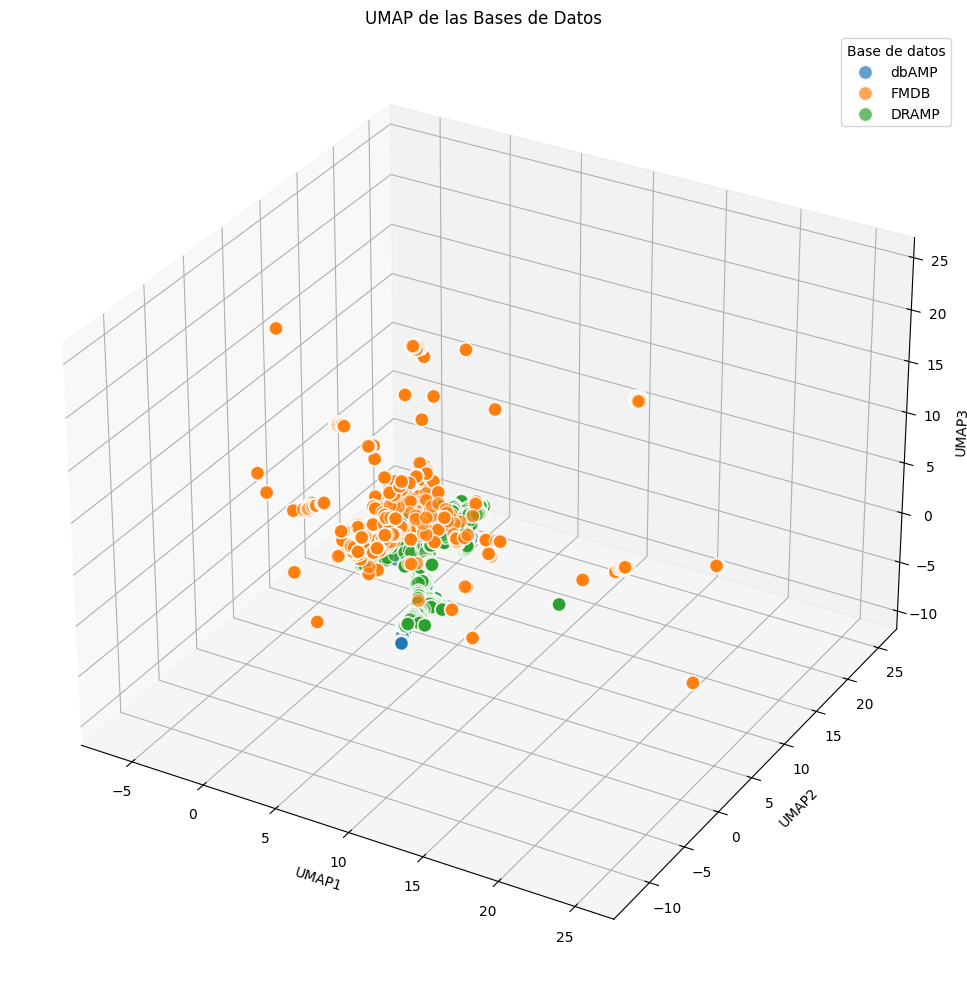

In [38]:
# UMAP con 3 componentes
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_components = umap_model.fit_transform(x)
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Graficar UMAP en 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for db_source, color in colors.items():
    subset = umap_df[umap_df['db_source'] == db_source]
    ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'], label=db_source, color=color, alpha=0.7, edgecolors='w', s=100)

ax.set_title('UMAP de las Bases de Datos')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.legend(title='Base de datos', loc='best')

plt.tight_layout()
plt.grid()
plt.savefig('graph_plots/umap_por_bd_cluster_3d.png', bbox_inches='tight', dpi=300)
plt.show()

In [39]:

# UMAP con 3 componentes
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_components = umap_model.fit_transform(x)
umap_df = pd.DataFrame(data=umap_components, columns=['UMAP1', 'UMAP2', 'UMAP3'])
umap_df['db_source'] = subsampled_data.loc[df_features.index, 'db_source']

# Transformar los Componentes UMAP 1, UMAP 2 y UMAP 3 a escala logarítmica
umap_df['UMAP1_log'] = np.log10(umap_df['UMAP1'] - umap_df['UMAP1'].min() + 1)
umap_df['UMAP2_log'] = np.log10(umap_df['UMAP2'] - umap_df['UMAP2'].min() + 1)
umap_df['UMAP3_log'] = np.log10(umap_df['UMAP3'] - umap_df['UMAP3'].min() + 1)

# Crear gráfico interactivo con plotly
fig = px.scatter_3d(
    umap_df,
    x='UMAP1_log',
    y='UMAP2_log',
    z='UMAP3_log',
    color='db_source',
    color_discrete_map=colors,
    title='UMAP de Bases de Datos',
    labels={
        'UMAP1_log': 'UMAP1 (log scale)',
        'UMAP2_log': 'UMAP2 (log scale)',
        'UMAP3_log': 'UMAP3 (log scale)',
        'db_source': 'Base de datos'
    }
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP1 (log scale)',
        yaxis_title='UMAP2 (log scale)',
        zaxis_title='UMAP3 (log scale)'
    )
)

fig.show()

# Guardar la figura como un archivo HTML
fig.write_html("graph_plots/umap_bds.html")

c:\Users\noral\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

